In [1]:
import sys
sys.path.append("../")  

import numpy as np 
import torch, time
import matplotlib.pyplot as plt
import sys
import utility, problem
import random
import net
from scipy.linalg import lstsq

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

# 设置随机种子
set_seed(42)

In [2]:
torch.set_default_dtype(torch.float64)
plt.rcParams.update({'font.size': 20})
def u_exact(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)

def f(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
    return 2 * torch.pi**2 * torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)

#### PD-OFM

c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss at Step 50 is 12.31948678744784 with pde loss 5.342700923393042 , orthogonal loss 697.6785864054797 and rank of matrix 43.
Loss at Step 100 is 1.787065322959661 with pde loss 0.22073393517291995 , orthogonal loss 156.6331387786741 and rank of matrix 47.
Final Loss at Step 133 is 1.1201559391824225 with pde loss 0.0917743128735925 , orthogonal loss 102.83816263088299.
after least squares
the error of least square in problem poisson2d:  2.876497854225554e-07
the effective rank of basis in problem poisson2d is 48 with threshold 0.001
the l2 relative error in problem poisson2d:  2.818177649121138e-09
the maximum pointwise error in problem poisson2d:  2.0084090418537315e-08


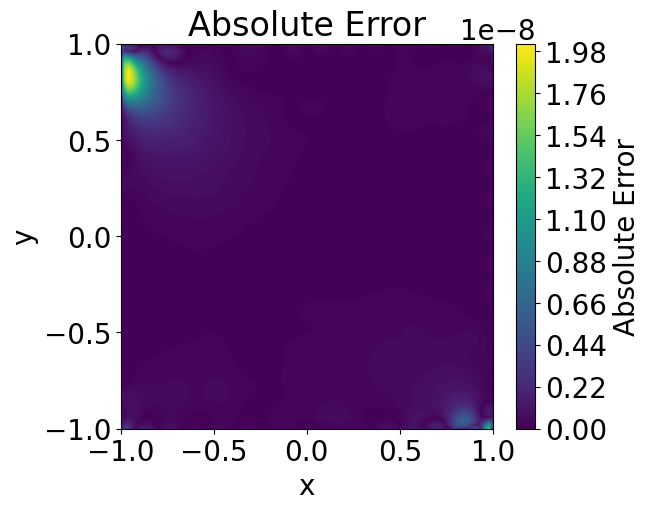

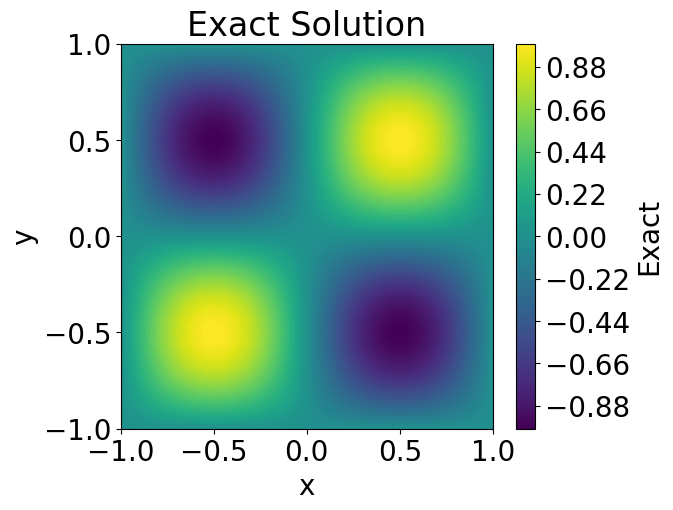

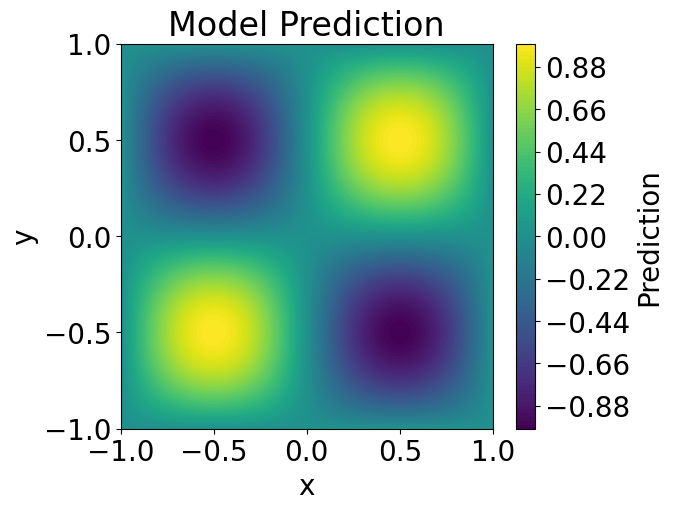

In [3]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.PoissonBox(f, u_exact, u_exact, domain_size=1, device=device)
params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 128, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 1000, "plotStep": 200, "writeStep": 50, "decay": 0.0001, "epsilon": 1e-3, "orthogonalpenalty": 0.01, "beta": 1}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = utility.trainnew(model,Pro,device,params,optimizer)

### PD-FM

Loss at Step 50 is 6.121432929715895 with pde loss 6.121432929715895 , orthogonal loss 12100.136506266821 and rank of matrix 53.
Loss at Step 100 is 0.38732988895510945 with pde loss 0.38732988895510945 , orthogonal loss 9809.748597401742 and rank of matrix 53.
Final Loss at Step 142 is 0.09161942011643043 with pde loss 0.09161942011643043 , orthogonal loss 10199.371248245594.
after least squares
the error of least square in problem poisson2d:  7.221440554731242e-07
the effective rank of basis in problem poisson2d is 54 with threshold 0.001
the l2 relative error in problem poisson2d:  9.62514738157165e-09
the maximum pointwise error in problem poisson2d:  5.351857937374582e-08


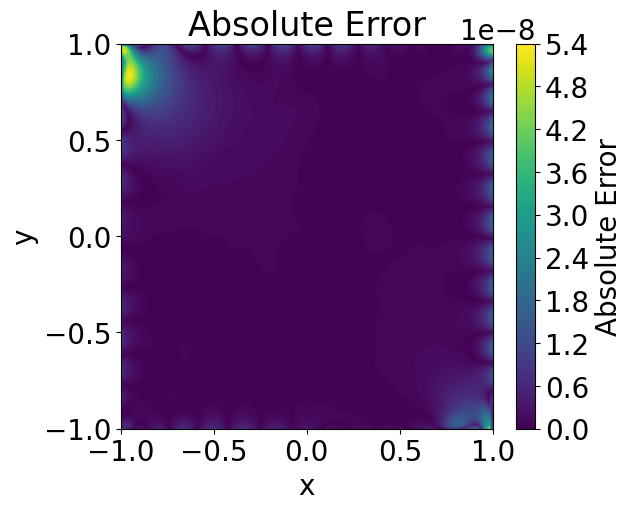

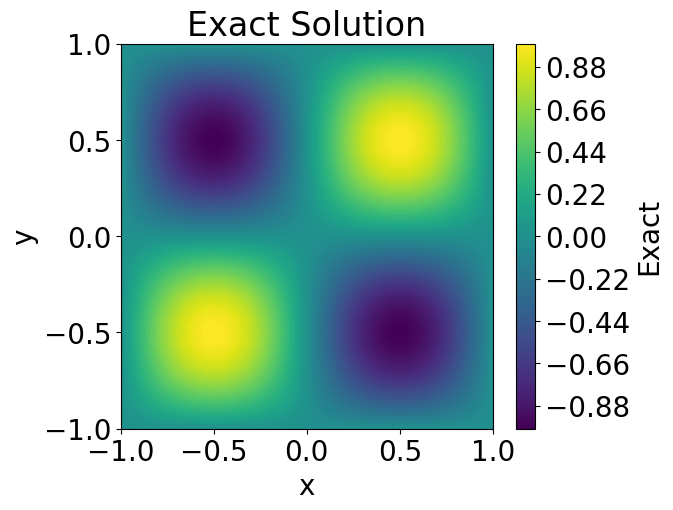

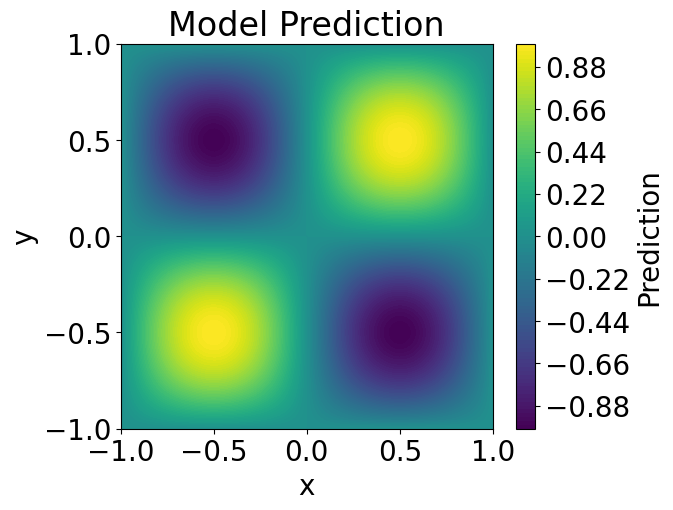

In [4]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.PoissonBox(f, u_exact, u_exact, domain_size=1, device=device)
params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 128, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 1000, "plotStep": 200, "writeStep": 50, "decay": 0.0001, "epsilon": 1e-3, "orthogonalpenalty": 0, "beta": 1}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = utility.trainnew(model,Pro,device,params,optimizer)

#### Transnet

c:\Users\29433\Desktop\Studying_Materials\2025spring\OrthoPINN\github_code\numerical_experiment\..\net.py:279: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3701.)
  alpha = torch.linalg.lstsq(basis_eval, grf_sample.T).solution  # (basis_num, 1)


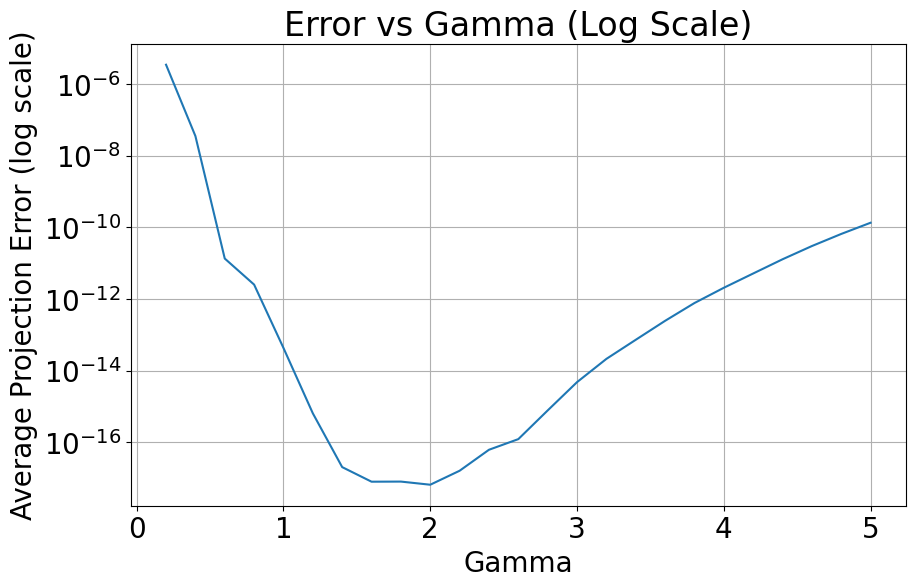

best shape parameter:  2.0
the error of least square in problem poisson2d:  1.4701446557225068e-05
the effective rank of basis in problem poisson2d is 67 with threshold 0.001
the l2 relative error in problem poisson2d:  1.432954203851511e-07
the maximum pointwise error in problem poisson2d:  7.499658067744841e-07


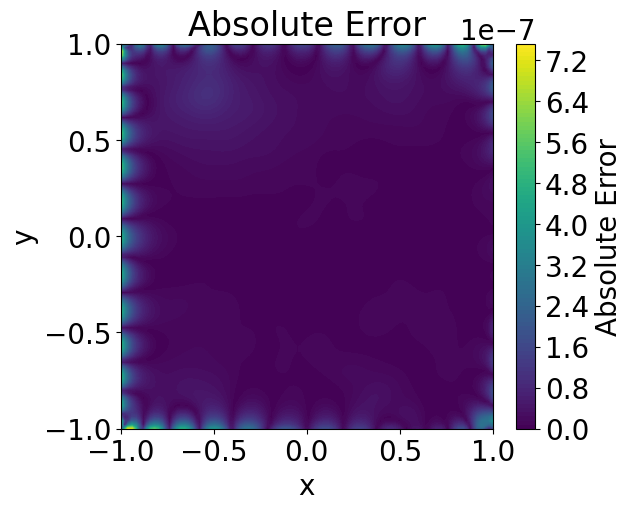

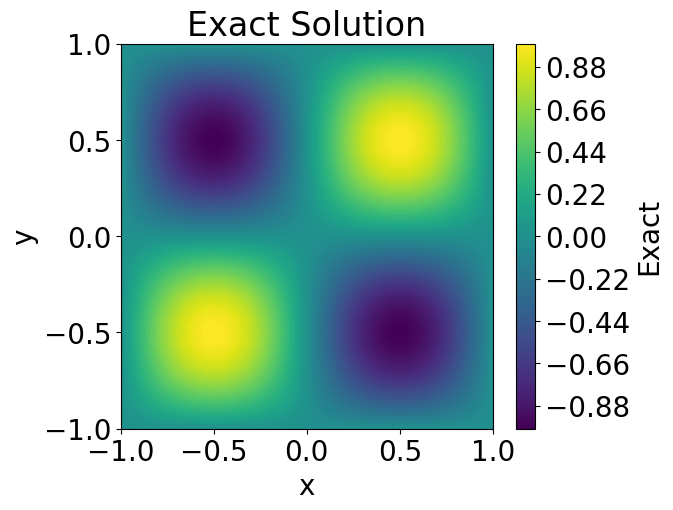

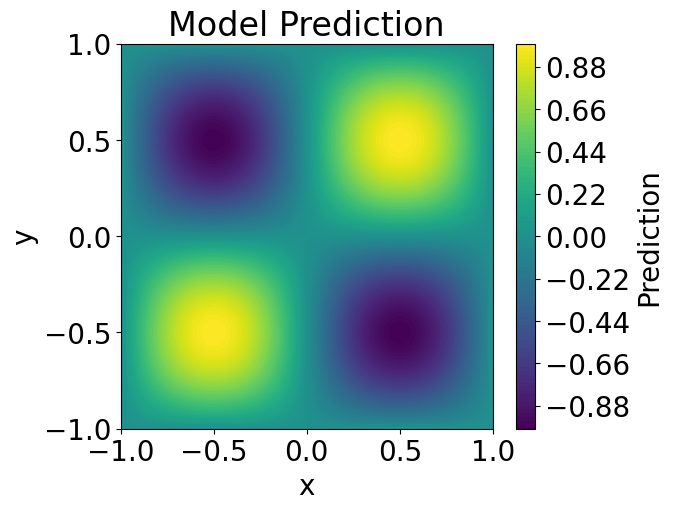

In [5]:
set_seed(42)

### Initializing TransNet and Problem
device = "cpu"
Pro = problem.PoissonBox(f, u_exact, u_exact, 1, device=device)
params = dict()
params = {"radius": 1.5, "d": 2, "bodyBatch": 1024, "bdryBatch":128, "width": 500}
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True
model = net.TransNet(params["d"], params["width"], params["radius"]).to(device)
print("best shape parameter: ", model.shape_parameter)

### Solving Least Sqaure Problem
(A, rhs) = Pro.leastsquareproblem(model, int_data, bdry_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)

### Random Feature Model

the error of least square in problem poisson2d:  8.032823784516147e-05
the effective rank of basis in problem poisson2d is 83 with threshold 0.001
the l2 relative error in problem poisson2d:  6.31105698136841e-06
the maximum pointwise error in problem poisson2d:  1.600355168701606e-05


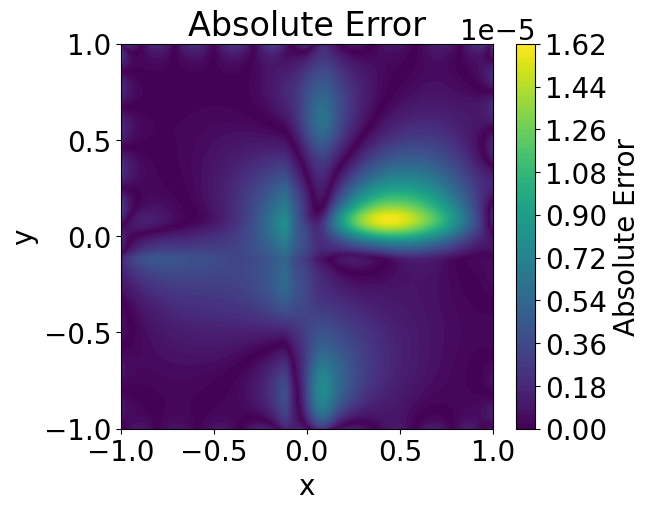

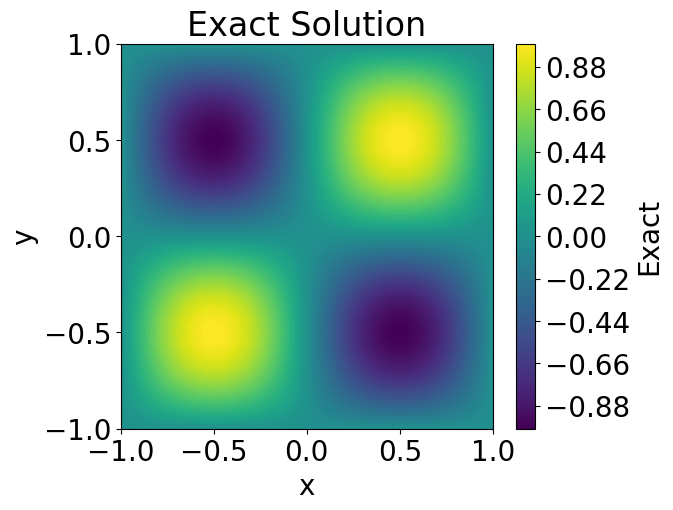

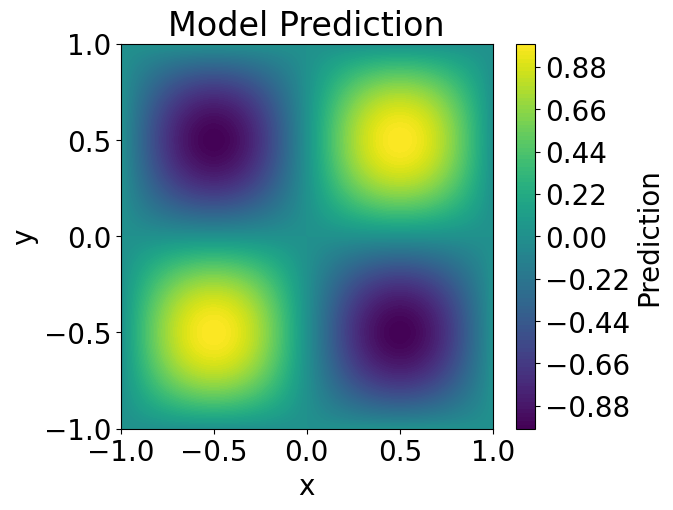

In [6]:
device="cpu"
set_seed(42)

### Initializing RFM and Problem
params = dict()
params = {"d": 2, "bodyBatch": 1024, "bdryBatch":128, "number_basis": 500}
centers = torch.tensor([[0.5,0.5],[-0.5,0.5],[0.5,-0.5],[-0.5,-0.5]], dtype=torch.float64).to(device)
radius = torch.tensor([[0.5,0.5],[0.5,0.5],[0.5,0.5],[0.5,0.5]], dtype=torch.float64).to(device)
model = net.RFM(params, centers, radius, typeofPoU="b", device=device).to(device)
Pro = problem.PoissonBox(f, u_exact, u_exact, 1, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"]) 
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True

### Solving Least Sqaure Problem
(A, rhs) = Pro.leastsquareproblem(model, int_data, bdry_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)